In [1]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import vtk as vtk

In [2]:
%matplotlib inline

# Try to load case with `pyvista.read`

PyVista is smart enough to allow the load of an OpenFOAM case (`.foam` extension here)

In [3]:
# Import the OpenFOAM example case
case = pv.read('./case.foam')

In [4]:
case.keys()

['internalMesh']

In [5]:
mesh = case[0]

In [6]:
mesh

UnstructuredGrid (0x1cd3f0ed460)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	10

* It looks like the number of arrays is doubled here, there is 2 times the `Data Arrays` (don't know why)
* It looks like the case is loaded for `time=0`, I don't know how to change the time value.

Here is for example below the U field where it's 0 everywhere expect at the inlet which is the intial condtion at `time=0`.

In [7]:
mesh.plot(scalars='U',cpos='xy')

# Load the case with `vtkOpenFOAMReader`

In [8]:
reader = vtk.vtkOpenFOAMReader() 
# vtkOpenFOAMReader creates a multiblock dataset. 
# reads a controlDict file, mesh information, and time dependent data. 
# The controlDict file contains timestep information. 
# The polyMesh folders contains mesh information 
# The time folders contains transient data for the cells. Each folder can contain any number of data files.
reader.SetFileName("case.foam")
# Indicate the file name
reader.UpdateInformation()
# Update the data if the file was modified 
time_array = reader.GetTimeValues()
# store the time values in an array
reader.SetTimeValue(time_array.GetRange()[1]) 
# Set read time to latest time step
reader.CreateCellToPointOff()
reader.Update()
# updates
multi_block = pv.wrap(reader.GetOutput())
# includes vtk objects (output of reader) in multiblock
mesh = multi_block[0]

In [9]:
multi_block[0]

UnstructuredGrid (0x1cd3f0eda60)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

## Let's make a simple contour plot

Let's plot the $u_x$ component of the velocity field

In [10]:
mesh.plot(scalars='U',component=0, cpos='xy')

## Let's use a different and more useful API

### Show the mesh 

In [11]:
# Create a plotting object to display vtk meshes or numpy arrays
p1 = pv.Plotter()
# Show the mesh in wireframe style
p1.add_mesh(mesh,style="wireframe",color="w")
# View in the xy plane
p1.view_xy()
# Show the axes
p1.add_axes()
# Display the plotting window
p1.show()

### An example with a field contour

In [12]:
p2 = pv.Plotter()
p2.add_mesh(mesh,scalars='U')
p2.view_xy()
p2.add_axes()
p2.show()

### Another one with the mesh surimposed

In [13]:
p3 = pv.Plotter()
p3.add_mesh(mesh,scalars='U', show_edges=True)
p3.view_xy()
p3.add_axes()
p3.show()

### Plot the velocity field using glyphs

In [14]:
geom = pv.Arrow()
glyphs = mesh.glyph(orient='U',scale='U-normed',factor=0.0005,geom=geom)
p4 = pv.Plotter()
p4.add_mesh(glyphs)
p4.view_xy()
p4.add_axes()
p4.show()

### Plot over line example

In [15]:
# Create the 2 points defining the line
a = [0, 0, 0]
b = [0, mesh.bounds[3], 0]

# Create a Line object
line = pv.Line(a, b)

In [16]:
mesh.bounds

[-0.020600000396370888,
 0.28999999165534973,
 -0.02539999969303608,
 0.02539999969303608,
 -0.0005000000237487257,
 0.0005000000237487257]

Let's show the line in the computational domain

In [44]:
p5 = pv.Plotter()
p5.add_mesh(mesh, style="wireframe", color='white')
# Show the line in red in the domain
p5.add_mesh(line, color="r", line_width=10)
p5.view_xy()
p5.add_axes()
p5.show()

Let's make a plot overline ...

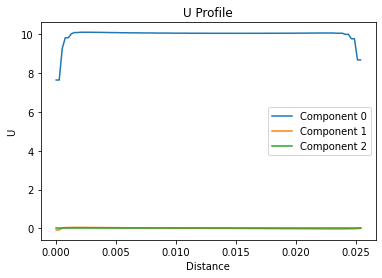

In [18]:
mesh.plot_over_line(a, b, resolution=100, scalars='U')

### How to access the vector components

List the available arrays 

In [19]:
mesh.cell_data

pyvista DataSetAttributes
Association     : CELL
Active Scalars  : U-normed
Active Vectors  : U
Active Texture  : None
Active Normals  : None
Contains arrays :
    U                       float32  (12225, 3)           VECTORS
    epsilon                 float32  (12225,)
    k                       float32  (12225,)
    nut                     float32  (12225,)
    p                       float32  (12225,)
    U-0                     float32  (12225,)
    U-normed                float32  (12225,)             SCALARS

Let's put the velocity vector field in `U`

In [20]:
U= mesh.cell_data['U']
np.shape(U)

(12225, 3)

Put each component in numpy arrays

In [21]:
ux = U[:,0]
uy = U[:,1]
uz = U[:,2]

# One can also use
ux = mesh['U'][:,0]
uy = mesh['U'][:,1]
uz = mesh['U'][:,2]

In [22]:
mesh.cell_data["ux"] = ux
mesh.cell_data["uy"] = uy
mesh.cell_data["uz"] = uz

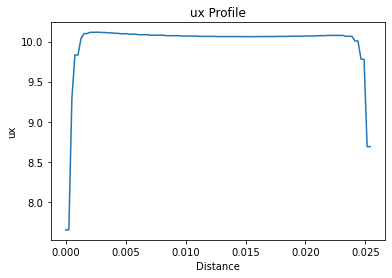

In [23]:
mesh.plot_over_line(a, b, resolution=100, scalars='ux')

### Plot a scalar over a circular arc

In [24]:
# Make two points at the bounds of the mesh and one at the center to
# construct a circular arc.
normal = [0, 0, 1]
polar = [0.02, 0, 0]
center = [0, 0, 0]
angle = 100.0

# Preview how this circular arc intersects this mesh
arc = pv.CircularArcFromNormal(center, 100, normal, polar, angle)

p = pv.Plotter()
p.add_mesh(mesh, style="wireframe", color="w")
p.add_mesh(arc, color="r")
a = arc.points[0]
b = arc.points[-1]
p.add_point_labels(
    [a, b], ["A", "B"], font_size=48, point_color="red", text_color="red"
)
p.view_xy()
p.show()


Let's see what's in the arc object.

In [25]:
arc

PolyData (0x1cd3b3d0dc0)
  N Cells:	1
  N Points:	101
  X Bounds:	-3.473e-03, 2.000e-02
  Y Bounds:	0.000e+00, 2.000e-02
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	2

I don't know how to add another plot on the same figure, it's perhaps only possible to plot one scalar or one vector at a time with this API.

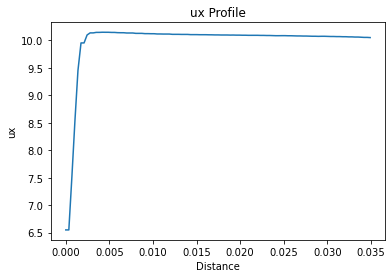

In [26]:
mesh.plot_over_circular_arc_normal(center, 100, normal, polar, angle,scalars='ux')
#mesh.plot_over_circular_arc_normal(center, 100, normal, polar, angle, scalars='uy')

So let's try another way and create the figure ourself (there may be better ways to do this by the way).

In [27]:
sampled = pv.DataSetFilters.sample_over_circular_arc_normal(mesh,
                                                         center,
                                                         100,
                                                         normal,
                                                         polar,
                                                         angle,
                                                         )

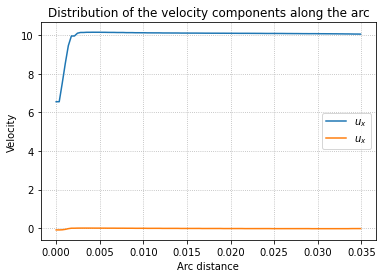

In [28]:
plt.figure()
plt.plot(sampled['Distance'],sampled['ux'],label='$u_x$')
plt.plot(sampled['Distance'],sampled['uy'],label='$u_x$')
plt.xlabel('Arc distance')
plt.ylabel('Velocity')
plt.title('Distribution of the velocity components along the arc')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

In [29]:
### fields

In [30]:
### k field 

p6 = pv.Plotter()
p6.add_mesh(mesh,scalars='k')
p6.view_xy()
p6.add_axes()
p6.show()

In [31]:
### espilon field 

p6 = pv.Plotter()
p6.add_mesh(mesh,scalars='epsilon')
p6.view_xy()
p6.add_axes()
p6.show()

In [32]:
### nut field 

p6 = pv.Plotter()
p6.add_mesh(mesh,scalars='nut')
p6.view_xy()
p6.add_axes()
p6.show()

In [33]:
### pressure field 

p6 = pv.Plotter()
p6.add_mesh(mesh,scalars='p')
p6.view_xy()
p6.add_axes()
p6.show()

In [34]:
### gradient 

### modification of the previous mesh "mesh" into a new mesh "mesh_g" with gradient calculated 

mesh_g = mesh.compute_derivative(scalars="U")
mesh_g

UnstructuredGrid (0x1cd3b557160)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	11

In [35]:
### plotting of du/dx 

p7 = pv.Plotter()
p7.add_mesh(mesh_g,scalars=mesh_g['gradient'][:,0])
p7.view_xy()
p7.add_axes()
p7.show()

In [36]:
### plotting of dv/dx

p8 = pv.Plotter()
p8.add_mesh(mesh_g,scalars=mesh_g['gradient'][:,1])
p8.view_xy()
p8.add_axes()
p8.show()

In [37]:
### multiplot, plotting of du/dx and dv/dx : hard visualization because of scaling pb (same scale for all the graphs)

plotter = pv.Plotter(shape=(1, 2))

plotter.subplot(0, 0)
plotter.add_text("du/dx", font_size=20)
plotter.add_mesh(mesh_g,scalars=mesh_g['gradient'][:,0])
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dv/dx", font_size=20)
plotter.add_mesh(mesh_g.copy(),scalars=mesh_g['gradient'][:,1])
plotter.view_xy()
plotter.add_axes()

plotter.show()

In [38]:
### multiplot, plotting all the gradient components 
### {du/dx, du/dy, du/dz, dv/dx, dv/dy, dv/dz, dw/dx, dw/dy, dw/dz}

In [39]:
plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("du/dx", font_size=20)
plotter.add_mesh(mesh_g,scalars=mesh_g['gradient'][:,0])
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("du/dy", font_size=20)
plotter.add_mesh(mesh_g.copy(),scalars=mesh_g['gradient'][:,1])
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("du/dz", font_size=20)
plotter.add_mesh(mesh_g.copy(),scalars=mesh_g['gradient'][:,2])
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("dv/dx", font_size=20)
plotter.add_mesh(mesh_g.copy(),scalars=mesh_g['gradient'][:,3])
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("dv/dy", font_size=20)
plotter.add_mesh(mesh_g.copy(),scalars=mesh_g['gradient'][:,4])
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("dv/dz", font_size=20)
plotter.add_mesh(mesh_g.copy(),scalars=mesh_g['gradient'][:,5])
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("dw/dx", font_size=20)
plotter.add_mesh(mesh_g.copy(),scalars=mesh_g['gradient'][:,6])
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("dw/dy", font_size=20)
plotter.add_mesh(mesh_g.copy(),scalars=mesh_g['gradient'][:,7])
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("dw/dz", font_size=20)
plotter.add_mesh(mesh_g.copy(),scalars=mesh_g['gradient'][:,8])
plotter.view_xy()
plotter.add_axes()

plotter.show()

In [90]:
### wall shear stress 

mu=0.000018
tau=mu*(mesh_g['gradient'][:,1])

p9 = pv.Plotter()
p9.add_mesh(mesh_g,scalars=tau)
p9.view_xy()
p9.add_axes()
p9.show()

In [ ]:
### plotting wall shear stress along the bottom 

In [82]:
### creation of the line which corresponds to the bottom 

a = [0, mesh.bounds[2], 0]
b = [mesh.bounds[1]-0.085, mesh.bounds[2], 0]

line1 = pv.Line(a, b)

p10 = pv.Plotter()
p10.add_mesh(mesh, style="wireframe", color='white')
p10.add_mesh(line1, color="r", line_width=10)
p10.view_xy()
p10.add_axes()
p10.show()

In [ ]:
mesh_g.point_data.update(gradients)

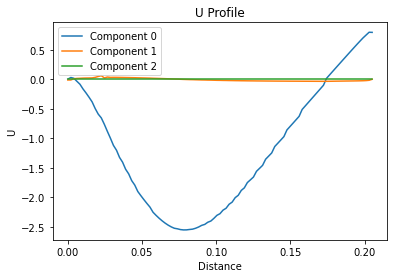

In [92]:
### plotting of wall shear stress over the line (bottom here) 
mesh.plot_over_line(a, b, resolution=100, scalars='U')

In [98]:
### plotting of wall shear stress over the line (bottom here) 

mesh.plot_over_line(a, b, resolution=100, scalars=mu*(mesh_g['gradient'][:,1]))

TypeError: GetAbstractArray argument %Id: %V

In [ ]:
### essayer de mettre les gradients dans le mesh pour ensuite avoir le bon type de data pour le plot overline d